In [1]:
import pandas
import numpy
import datetime
import aacgmv2
import os
os.environ["CDF_LIB"] = "cdf36_4-dist/lib"
from spacepy import pycdf
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from davitpy import utils
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# SSM File
selSsmFile = "../data/dmsp/dmsp-f18_ssm_magnetometer_20110705_v1.0.4.cdf"
# time ranges
selTimeRange = [ datetime.datetime(2011,7,5,4,0),\
               datetime.datetime(2011,7,5,4,30) ]
mapTime = datetime.datetime( 2011,7,5,4,30 )
#coords
coords = "mlt"
# misc. Constants
delLatDist = 111*1e3 #meters
mu0 = 1.25*1e-6

In [3]:
def running_mean(inpArr, windowSize=20):
    return numpy.convolve( inpArr,\
                numpy.ones((windowSize,))/windowSize, mode='same')

In [4]:
cdf = pycdf.CDF(selSsmFile)
# create a SSMDF
ssmDF = pandas.DataFrame( {
    "date" : cdf['Epoch'][:].flatten(),
    "dB_across" : -1*cdf['DELTA_B_SC'][:,2].flatten(),
    "dB_along" : cdf['DELTA_B_SC'][:,1].flatten(),
    "dB_up" : -1*cdf['DELTA_B_SC'][:,0].flatten(),
    "dBX" : cdf['DELTA_B_SC_ORIG'][:,0].flatten(),
    "dBY" : cdf['DELTA_B_SC_ORIG'][:,1].flatten(),
    "dBZ" : cdf['DELTA_B_SC_ORIG'][:,2].flatten(),
    "dB_east" : cdf['DELTA_B_GEO'][:,0].flatten(),
    "dB_north" : cdf['DELTA_B_GEO'][:,1].flatten(),
    "dBUp" : cdf['DELTA_B_GEO'][:,2].flatten(),
    "glat" : cdf['SC_GEOCENTRIC_LAT'][:].flatten(),
    "glon" : cdf['SC_GEOCENTRIC_LON'][:].flatten(),
    "mlat" : cdf['SC_AACGM_LAT'][:].flatten(),
    "mlon" : cdf['SC_AACGM_LON'][:].flatten(),
    "mlt" : cdf['SC_AACGM_LTIME'][:].flatten(),
    "aur_reg" : cdf['AURORAL_REGION'][:].flatten()
} )
# filter ssmDF to required times
ssmDF = ssmDF[ (ssmDF["date"] >= selTimeRange[0]) &\
             (ssmDF["date"] <= selTimeRange[1]) ]
# # dropt na values
ssmDF = ssmDF[ pandas.notnull(ssmDF["dBZ"]) ].reset_index(drop=True)
# get a rolling mean of dBZ
ssmDF['smooth_dBZ'] = ssmDF['dBZ'].rolling(20).mean()
# Get db(y,z) magn and azim
ssmDF["db_magn"] = numpy.sqrt( numpy.square(ssmDF["dBY"]) +\
                             numpy.square(ssmDF["dBZ"]))
ssmDF["db_azim"] = numpy.rad2deg( numpy.arctan( ssmDF["dBY"]/ssmDF["dBZ"] ) )
ssmDF.head()

,aur_reg,dBUp,dBX,dBY,dBZ,dB_across,dB_along,dB_east,dB_north,dB_up,date,glat,glon,mlat,mlon,mlt,smooth_dBZ,db_magn,db_azim
0,1.0,3.051105,64.184174,-95.708038,-35.086330,-3.658124,9.026205,1.916354,9.548918,3.051105,2011-07-05 04:00:00.138,34.134041,236.685345,43.290313,302.232304,19.207064,NaN,101.936646,69.867180
1,1.0,2.729965,64.491722,-95.615219,-35.387718,-3.326070,9.098945,1.575321,9.558865,2.729965,2011-07-05 04:00:01.138,34.191968,236.667922,43.337950,302.200902,19.205241,NaN,101.953720,69.690208
2,1.0,2.378775,64.829437,-95.505142,-35.683952,-2.999114,9.189274,1.236016,9.586955,2.378775,2011-07-05 04:00:02.138,34.249894,236.650480,43.385589,302.169450,19.203416,NaN,101.953796,69.512604
3,1.0,1.997489,65.197365,-96.362915,-35.010212,-3.642076,8.312086,2.029857,8.845065,1.997489,2011-07-05 04:00:03.138,34.307818,236.633020,43.433235,302.137978,19.201589,NaN,102.525734,70.033096
4,1.0,2.587342,64.594269,-96.232666,-35.260693,-3.360762,8.423252,1.731609,8.902102,2.587342,2011-07-05 04:00:04.138,34.365743,236.615541,43.480922,302.106469,19.199759,NaN,102.489227,69.876617


In [5]:
# Now we need to plot vectors of dBZ
# we'll do it by setting an azimuth of -90.
# first we need normMLT, otherwise endPtMLT 
# calculations will get messed up.
vecScale = 500.
ssmDF["normMLT"] = [ x-24. if x>12. else x for x in ssmDF["mlt"] ]
# Now calculate the endPts
ssmDF["endPtMLAT"] = numpy.round( (ssmDF["db_magn"]/vecScale) *\
                                numpy.cos( -1*numpy.deg2rad(ssmDF["db_azim"]) ) +\
                                ssmDF["mlat"], 2)
ssmDF["endPtMlon"] = numpy.round( (ssmDF["db_magn"]/vecScale) *\
                                numpy.sin( -1*numpy.deg2rad(ssmDF["db_azim"]) ) +\
                                ssmDF["mlon"], 2)
ssmDF["endPtNormMLT"] = numpy.round( (ssmDF["db_magn"]/vecScale) *\
                                numpy.sin( -1*numpy.deg2rad(ssmDF["db_azim"]) ) +\
                                ssmDF["normMLT"], 2)
ssmDF["endPtMLT"] = [ x + 24. if x < 0. else x for x in ssmDF["endPtNormMLT"] ]

In [6]:
# convert to map coords
if coords != "geo":
    ssmLats = ssmDF["mlat"].values
    if coords == "mlt":
        ssmLons = ssmDF["mlt"].values*15.
    else:
        ssmLons = ssmDF["mlon"].values
else:
    ssmLats = ssmDF["glat"].values
    ssmLons = ssmDF["glon"].values
bVecs = ssmDF["dB_across"].values

/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


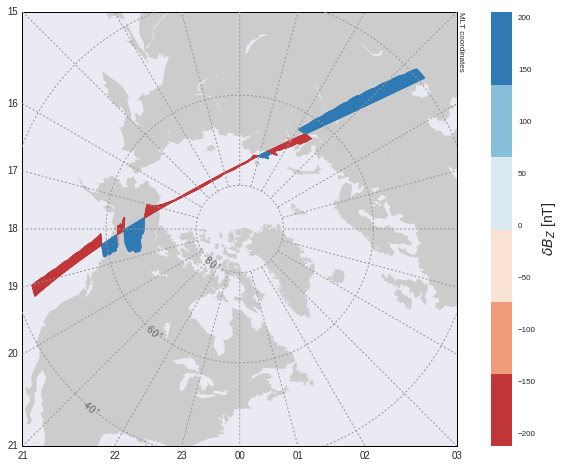

In [7]:
#seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
# setup fig
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1,1,1)
# set colorbar
seaMap = ListedColormap(sns.color_palette("RdBu"))
mapHandle = utils.plotUtils.mapObj(boundinglat=40., coords=coords,\
                           lat_0=90., lon_0=0, datetime=mapTime)
# xVecs, yVecs = mapHandle(ssmLons, ssmLats, coords=coords)
# ssmPlot = mapHandle.scatter(xVecs, yVecs, c=bVecs, s=10.,\
#                        cmap="Greens", alpha=0.7, zorder=7., \
#                                  edgecolor='none', marker="s",\
#                            vmin=-100., vmax=100.)
# plot the dBZ vecs
dbzScaleMin = ssmDF["dBZ"].min()
dbzScaleMax = ssmDF["dBZ"].max()
colNorm = Normalize( vmin=dbzScaleMin, vmax=dbzScaleMax )
for row in ssmDF.iterrows():
    currCol = seaMap( row[1]["dBZ"] )
    currXVecBgn, currYVecBgn = mapHandle(row[1]["mlt"]*15., row[1]["mlat"], coords=coords)
    currXVecEnd, currYVecEnd = mapHandle(row[1]["endPtMLT"]*15., row[1]["endPtMLAT"], coords=coords)
    velPlot = ax.plot( [currXVecBgn, currXVecEnd], [ currYVecBgn, currYVecEnd ], color=currCol )     
#     ax.arrow( currXVecBgn, currYVecBgn, currXVecEnd-currXVecBgn, currYVecEnd-currYVecBgn,\
#              head_width=1e5, head_length=5e4, fc=currCol, ec=currCol)
    
sm = plt.cm.ScalarMappable(cmap=seaMap, norm=Normalize(vmin=dbzScaleMin, vmax=dbzScaleMax))   
sm._A = []
plt.colorbar(sm, ax=ax)
sm.colorbar.ax.set_ylabel(r"$ \delta B_{Z}$ [nT]", fontsize=14)
fig.savefig("../plots/ssm-" + mapTime.strftime("%Y%m%d") + ".pdf" ,bbox_inches='tight')

In [8]:
# estimate the currents from mag. fld. pertubations
delBzValsMean = running_mean(ssmDF["dBZ"].values)#ssmDF["smooth_dBZ"].values#
diffBz = numpy.ediff1d( delBzValsMean, to_begin=0 )*1e-9 # convert from nT to T
diffLat = numpy.ediff1d( ssmDF["mlat"].values, to_begin=0 )*delLatDist # convert to meters
# sometimes the current estimates are pretty high
# replace them with nan's
diffLat[ numpy.abs(diffLat) <= 500. ] = numpy.nan
facDen = numpy.divide( diffBz, diffLat )*1e6/mu0 # convert to microAmps/m2

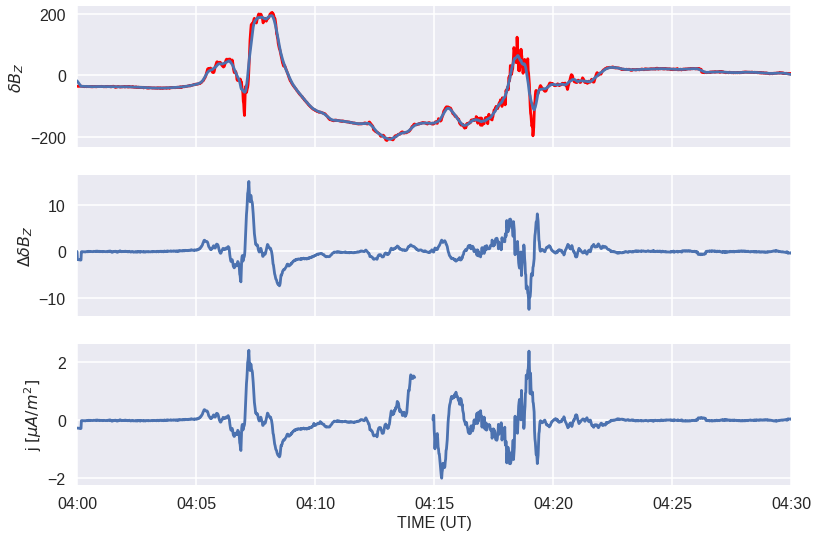

In [9]:
# Setup Fig
sns.set_style("darkgrid")
sns.set_context("poster")
f, axArr = plt.subplots(3, sharex=True)
# plot the data
axArr[0].plot(ssmDF["date"].values, ssmDF["dBZ"].values, 'r' )
axArr[0].plot(ssmDF["date"].values, delBzValsMean )
axArr[1].plot(ssmDF["date"].values, diffBz*1e9) # converting to nT
axArr[2].plot(ssmDF["date"].values, facDen)

# ax labels
axArr[0].set_ylabel(r"$ \delta B_{Z}$", fontsize=16)
axArr[1].set_ylabel(r"$\Delta \delta B_{Z}$", fontsize=16)
axArr[2].set_ylabel(r"j $ [\mu A/m^{2}]$", fontsize=16)
# x-label
axArr[-1].set_xlabel("TIME (UT)", fontsize=16)
# format the axes
for axx in axArr:
    axx.set_xlim( [selTimeRange[0], selTimeRange[1]] )
    axx.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))

# axArr[-1].set_ylim( [-2,2] )

# Mark lines on auroral region crossing
# get aur bnds, note aur_regs are indicated
# by the number 2 in the data.
aurDates = ssmDF[ ssmDF["aur_reg"] == 2 ]["date"].values
# for axx in axArr:
#     axx.axvline( x=aurDates.min(), c='r', linestyle=":", linewidth=3. )
#     axx.axvline( x=aurDates.max(), c='r', linestyle=":", linewidth=3. )

f.savefig( "../plots/ssm-ts-" + selTimeRange[0].strftime("%Y%m%d") + ".pdf",bbox_inches='tight' )